In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

def fast_show_mask_gpu(
    annotation,
    ax,
    random_color=False,
    bbox=None,
    retinamask=True,
    target_height=960,
    target_width=960,
):
    device = annotation.device
    mask_sum = annotation.shape[0]
    height = annotation.shape[1]
    weight = annotation.shape[2]
    areas = torch.sum(annotation, dim=(1, 2))
    sorted_indices = torch.argsort(areas, descending=False)
    annotation = annotation[sorted_indices]
    # 找每个位置第一个非零值下标
    index = (annotation != 0).to(torch.long).argmax(dim=0)
    if random_color == True:
        color = torch.rand((mask_sum, 1, 1, 3)).to(device)
    else:
        color = torch.ones((mask_sum, 1, 1, 3)).to(device) * torch.tensor(
            [30 / 255, 144 / 255, 255 / 255]
        ).to(device)
    transparency = torch.ones((mask_sum, 1, 1, 1)).to(device) * 0.6
    visual = torch.cat([color, transparency], dim=-1)
    mask_image = torch.unsqueeze(annotation, -1) * visual
    # 按index取数，index指每个位置选哪个batch的数，把mask_image转成一个batch的形式
    mask = torch.zeros((height, weight, 4)).to(device)
    h_indices, w_indices = torch.meshgrid(torch.arange(height), torch.arange(weight))
    indices = (index[h_indices, w_indices], h_indices, w_indices, slice(None))
    # 使用向量化索引更新show的值
    mask[h_indices, w_indices, :] = mask_image[indices]
    mask_cpu = mask.cpu().numpy()
    if bbox is not None:
        x1, y1, x2, y2 = bbox
        ax.add_patch(
            plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="b", linewidth=1
            )
        )
    if retinamask == False:
        mask_cpu = cv2.resize(
            mask_cpu, (target_width, target_height), interpolation=cv2.INTER_NEAREST
        )
    return mask_cpu

def fast_process(
    annotations,
    image,
    device,
    scale,
    better_quality=False,
    mask_random_color=True,
    bbox=None,
    use_retina=True,
    withContours=True,
):
    if isinstance(annotations[0], dict):
        annotations = [annotation["segmentation"] for annotation in annotations]

    original_h = image.height
    original_w = image.width
    if better_quality:
        if isinstance(annotations[0], torch.Tensor):
            annotations = np.array(annotations.cpu())
        for i, mask in enumerate(annotations):
            mask = cv2.morphologyEx(
                mask.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8)
            )
            annotations[i] = cv2.morphologyEx(
                mask.astype(np.uint8), cv2.MORPH_OPEN, np.ones((8, 8), np.uint8)
            )

    if isinstance(annotations[0], np.ndarray):
        annotations = np.array(annotations)
        annotations = torch.from_numpy(annotations)
    inner_mask = fast_show_mask_gpu(
        annotations,
        plt.gca(),
        random_color=mask_random_color,
        bbox=bbox,
        retinamask=use_retina,
        target_height=original_h,
        target_width=original_w,
    )
    image = image.convert("RGBA")
    overlay_inner = Image.fromarray((inner_mask * 255).astype(np.uint8), "RGBA")
    #image.paste(overlay_inner, (0, 0), overlay_inner)
    return image, overlay_inner

In [2]:

img = Image.open("/opt/ml/input/code/MobileSAM/app/assets/picture1.jpg")

In [3]:
input_size = 1024
w, h = img.size
scale = input_size / max(w, h)
new_w = int(w * scale)
new_h = int(h * scale)
image = img.resize((new_w, new_h))

In [5]:
from mobile_sam import sam_model_registry
model_type = "vit_t"
sam_checkpoint = "./weights/mobile_sam.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
mobile_sam.eval()

Sam(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
 

In [6]:
from mobile_sam import SamAutomaticMaskGenerator
import numpy as np 

mask_generator = SamAutomaticMaskGenerator(mobile_sam)
masks = mask_generator.generate(np.array(image))

In [ ]:
fig, mask = fast_process(
        annotations=masks,
        image=image,
        device=device,
        scale=(1024),
        mask_random_color=True,
        bbox=None,
        withContours=True,
    )


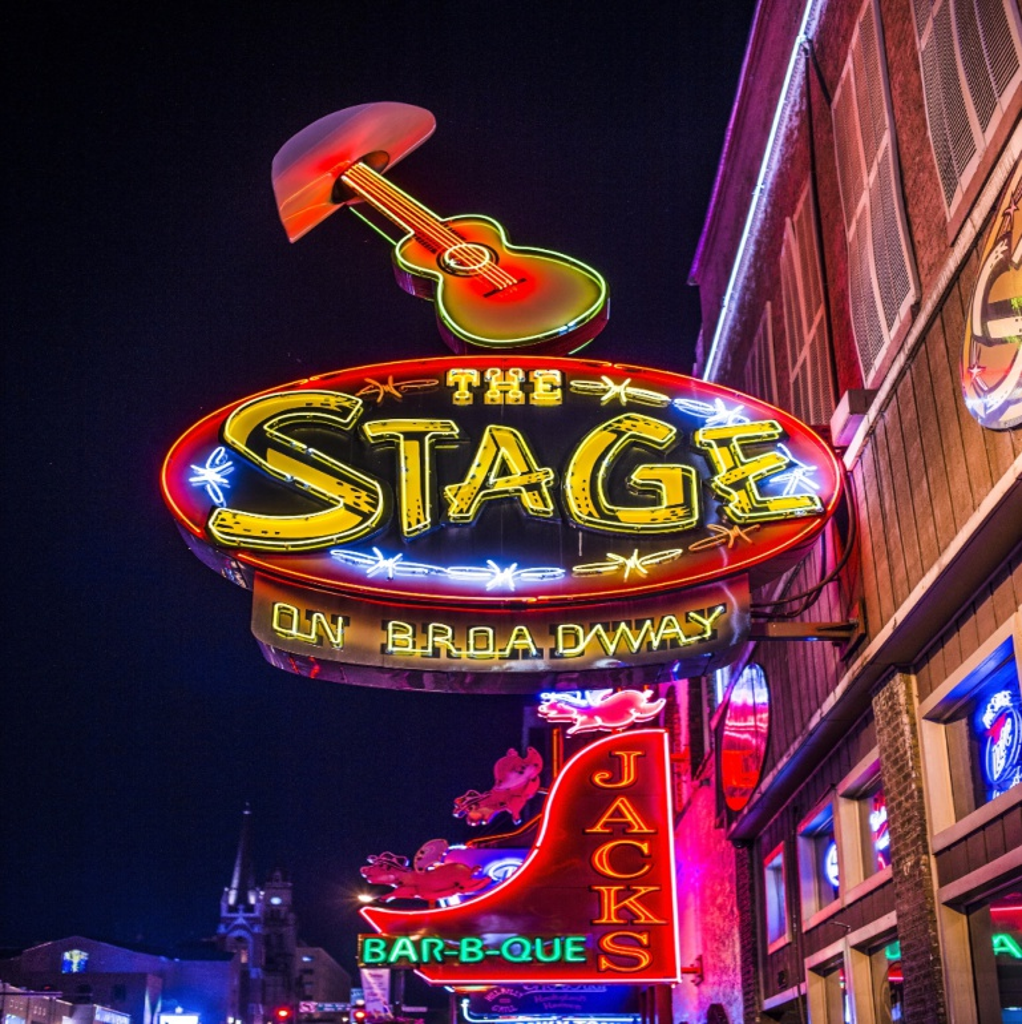

In [11]:
fig

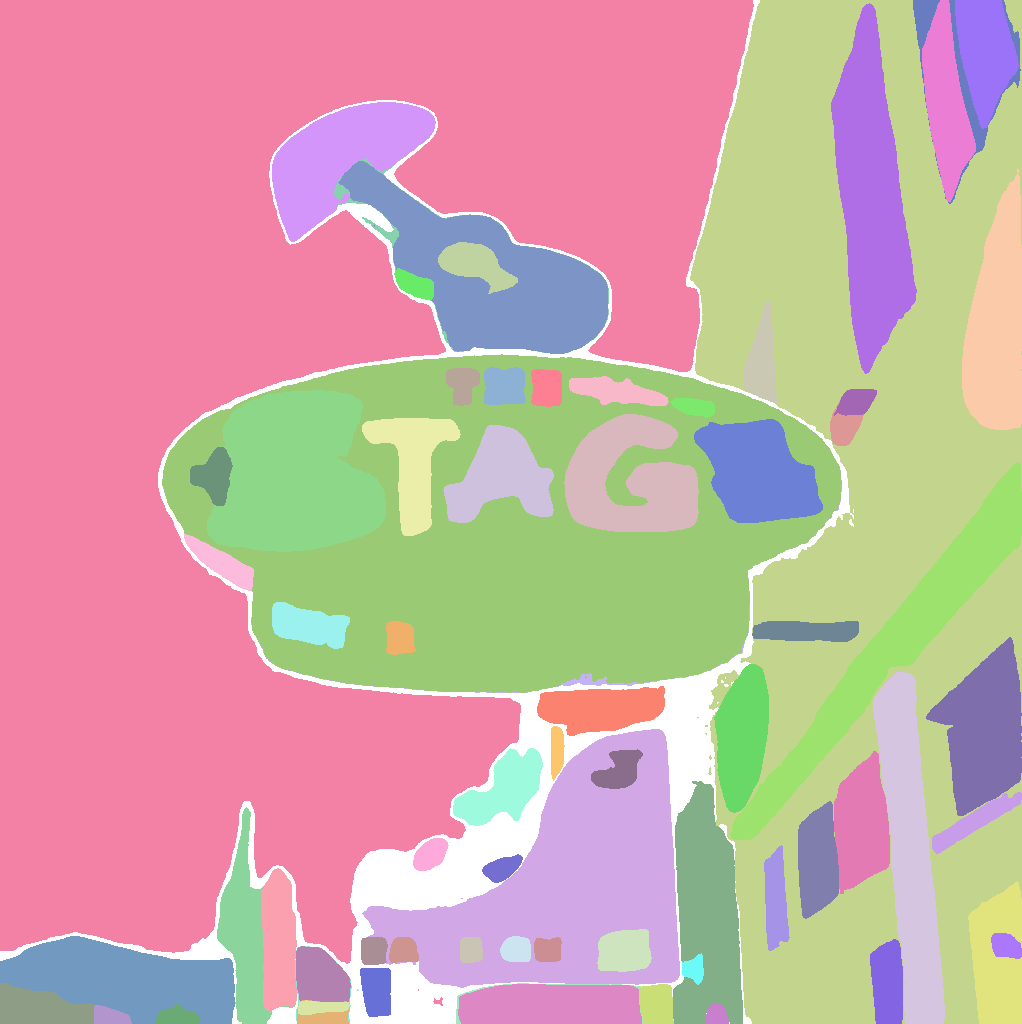

In [13]:
mask

In [14]:
fig.paste(mask, (0, 0), mask)


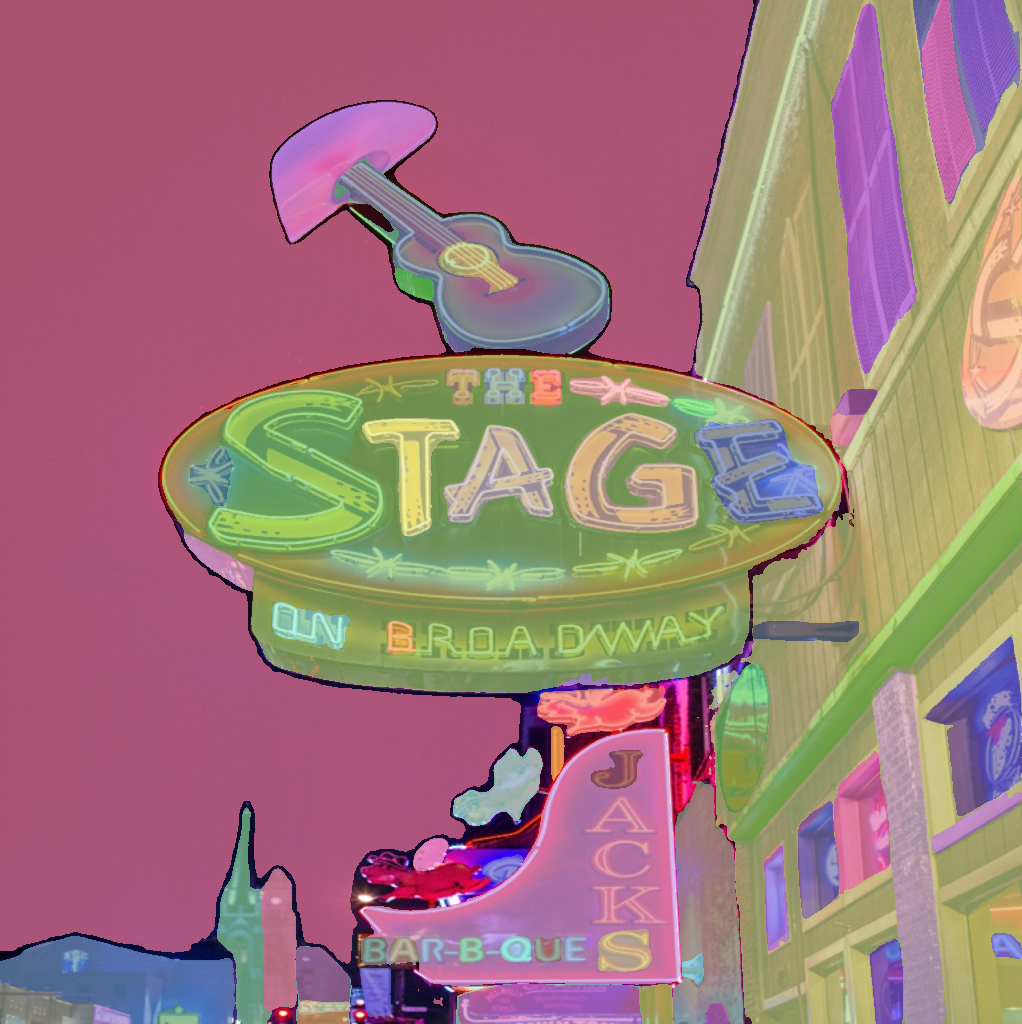

In [15]:
fig

In [17]:
import torch
torch.__version__

'2.0.1+cu117'